In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import pdb
import numpy as np
import numpy.random as npr
import tensorflow as tf
from tensorflow.python.ops import parallel_for as pfor
import sys
import json
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from scipy import stats
from numpy import linalg as LA
from sklearn import linear_model
from sklearn.manifold import MDS
from sklearn.neighbors import DistanceMetric

import getpass
ui = getpass.getuser()
if ui == 'laura':
    p = '/home/laura'
elif ui == 'lauradriscoll':
    p = '/Users/lauradriscoll/Documents'
### DAVID : this is the path to my code and data folders, probably add yours

In [2]:
tf.__version__

'1.10.0'

In [3]:
### DAVID tf version is '1.10.0'

In [9]:
net = 'stepnet'
### DAVID : this directs to a folder within the code from github
PATH_YANGNET = os.path.join(p,'code/multitask-nets',net) 

sys.path.insert(0, PATH_YANGNET)
from task import generate_trials, rule_name, rule_index_map, rules_dict
from network import Model
import tools
from tools_lnd import name_best_ckpt, plot_FP, plot_N

In [10]:
rule_set = ['fdgo', 'reactgo', 'delaygo', 'fdanti', 'reactanti', 'delayanti',
              'delaydm1', 'delaydm2', 'contextdelaydm1', 'contextdelaydm2', 'multidelaydm',
              'dmsgo', 'dmsnogo', 'dmcgo', 'dmcnogo']

rule_set_names = ['DelayGo', 'ReactGo', 'MemoryGo', 'DelayAnti', 'ReactAnti', 'MemoryAnti',
              'Decison1', 'Decison2', 'ContextDecison1', 'ContextDecison2', 'MultiDecison',
              'DelayDecison1', 'DelayDecison2', 'ContextDelayDecison1', 'ContextDelayDecison2', 'MultiDelayDecison',
              'DelayMatch2SampleGo', 'DelayMatch2SampleNogo', 'DelayMatch2CategoryGo', 'DelayMatch2CategoryNoGo']

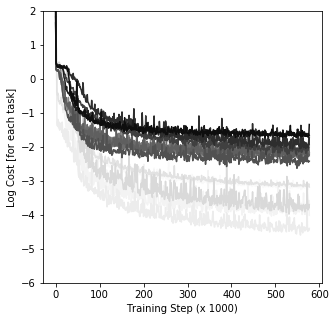

In [56]:
#This plot just shows progress over training to convince that the network looks sufficiently trained
dir_set = ['no_noise', 'no_reg','l2h00001','l2w0001','l2w00001'] 
dir_specific = dir_set[2]
model_n = 0
# model_dir_all = os.path.join(p,'data/networks_for_david/',dir_specific,str(model_n))
model_dir_all = os.path.join(p,'data/rnn/multitask/stepnet/crystals/softplus/',dir_specific,str(model_n))
task_set = np.concatenate((range(6),range(11,20)))#[13,14] # these are the tasks i actually train on

fig = plt.figure(figsize=(5, 5))
cmap=plt.get_cmap('Greys')
fname = os.path.join(model_dir_all, 'log.json')

with open(fname, 'r') as f:
    log_all = json.load(f)
for r in task_set:
    c = cmap(r/20)
    ax = fig.add_subplot(1,1,1)
    x = np.log(log_all['cost_'+rules_dict['all'][r]])
    plt.plot(x,'-',c = c)
    ax.set_xlabel('Training Step (x 1000)')
    ax.set_ylabel('Log Cost [for each task]')
    plt.ylim([-6,2])
plt.show()    

In [62]:
hparams

{u'activation': u'softplus',
 u'alpha': 0.2,
 u'batch_size_test': 8192,
 u'batch_size_train': 64,
 u'c_intsyn': 0,
 u'delay_fac': 1,
 u'dt': 20,
 u'in_type': u'normal',
 u'ksi_intsyn': 0,
 u'l1_h': 0,
 u'l1_weight': 0,
 u'l2_h': 1e-05,
 u'l2_weight': 0,
 u'l2_weight_init': 0,
 u'learning_rate': 0.001,
 u'loss_type': u'lsq',
 u'n_eachring': 2,
 u'n_input': 25,
 u'n_output': 3,
 u'n_rep': 256,
 u'n_rnn': 256,
 u'n_rule': 20,
 u'num_ring': 2,
 u'optimizer': u'adam',
 u'p_weight_train': None,
 'rng': <mtrand.RandomState at 0x7f891d930910>,
 u'rnn_type': u'LeakyRNN',
 u'rule_probs': [0.06666666666666667,
  0.06666666666666667,
  0.06666666666666667,
  0.06666666666666667,
  0.06666666666666667,
  0.06666666666666667,
  0.06666666666666667,
  0.06666666666666667,
  0.06666666666666667,
  0.06666666666666667,
  0.06666666666666667,
  0.06666666666666667,
  0.06666666666666667,
  0.06666666666666667,
  0.06666666666666667],
 u'rule_start': 5,
 u'rule_trains': [u'fdgo',
  u'reactgo',
  u'delayg

In [57]:
print(model_dir_all)

/Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2h00001/0


0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2h00001/0/ckpts/model.ckpt-529000


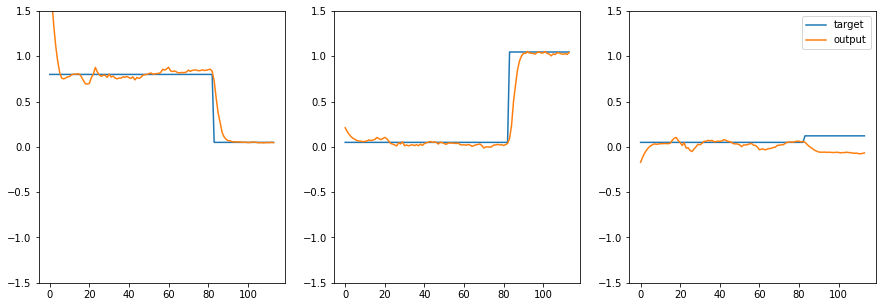

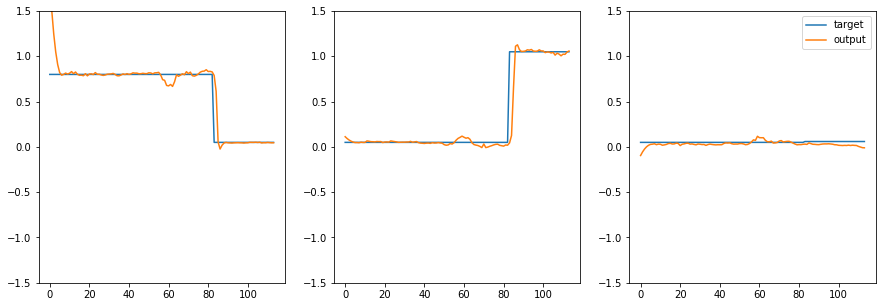

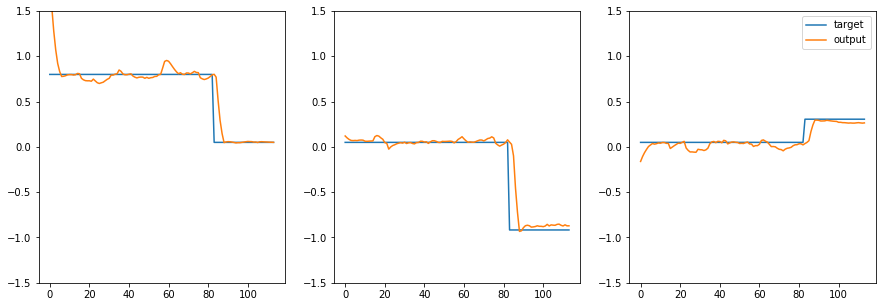

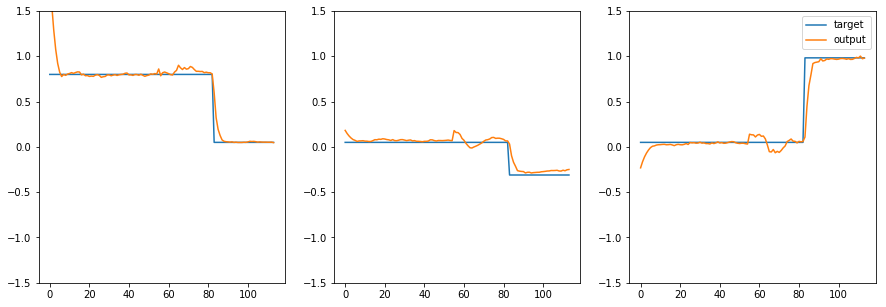

In [58]:
#These plots show some targets and outputs, again to show that the network looks sufficiently trained

rule = 'contextdelaydm1'
ckpt_n = name_best_ckpt(model_dir_all,rule)
ckpt_n_dir = os.path.join(model_dir_all,'ckpts/model.ckpt-' + str(int(ckpt_n)))

model = Model(model_dir_all)
with tf.Session() as sess:
    model.saver.restore(sess,ckpt_n_dir)
    model._sigma=0
    var_list = model.var_list
    hparams = model.hp
    trial = generate_trials(rule, hparams, mode='random', noise_on=True, batch_size =100, delay_fac =1)
    feed_dict = tools.gen_feed_dict(model, trial, hparams)
    h_tf, y_hat_tf = sess.run([model.h, model.y_hat], feed_dict=feed_dict) 
    
for y in range(4): # look at outputs compared to targets on 4 trials
    fig = plt.figure(figsize=(15, 5))
    for x in range(1,4): #three outputs
        ax = fig.add_subplot(1,3,x)
        plt.plot(trial.y[:,y,x-1],label = 'target')
        plt.plot(y_hat_tf[:,y,x-1],label = 'output')
        plt.ylim([-1.5,1.5])
        
    plt.legend()
    plt.show()

In [59]:
def plot_N_jitter(m,D_use,rule,fp_epoch,rand_step_coef = 0.01,n_steps = 70,n_jit = 50,
                   lw = 3,al = .6,linestyle = '-',mode = 'test', batch_size = 100):

    cmap=plt.get_cmap('rainbow')
        
    model = Model(m)
    with tf.Session() as sess:
        model.restore()
        hparams = model.hp
        model._sigma=0

        trial = generate_trials(rule, hparams, mode=mode,noise_on=False, batch_size = 100,delay_fac = 1)
        
        feed_dict = tools.gen_feed_dict(model, trial, hparams)
        h_tf, _ = sess.run([model.h, model.y_hat], feed_dict=feed_dict) #(n_time, n_condition, n_neuron)
        T,S,N = np.shape(h_tf)
        T_inds = get_T_inds(trial,fp_epoch) # grab epoch time indexing
                                
        if mode=='test':
            trial_set = range(0,S,int(S/8))
        else:
            trial_set = range(0,S,int(S/50))

        for s in trial_set:

            c_inds = trial.y_loc[-1,s]/(2*np.pi)#s/np.max(trial_set)#
            c = cmap(c_inds)

            X_trial = np.dot(h_tf[T_inds,s,:],D_use)
            plt.plot(X_trial[0,0],X_trial[0,1],'x',c = c, alpha = al, linewidth = lw)
            plt.plot(X_trial[:,0],X_trial[:,1],linestyle,c = c, alpha = al, linewidth = lw)
            plt.plot(X_trial[-1,0],X_trial[-1,1],'^',c = c, alpha = al, linewidth = lw,markersize = 1)

            x_t = np.matlib.repmat(trial.x[T_inds[1],s,:],n_steps,1)
            for jit in range(n_jit):
                h0 = h_tf[T_inds[0]-1,s,:] + rand_step_coef*npr.randn(N)
                h_t = vanilla_run_with_h0(params, x_t, h0, alpha)
                jitter = np.dot(h_t,D_use)
                plt.plot(jitter[-1,0],jitter[-1,1],'^',c = c,linewidth = .1,alpha = .1)
                plt.plot(jitter[:,0],jitter[:,1],'-',c = c,linewidth = .5,alpha = .5)

In [60]:
from tools_lnd import get_T_inds,make_h_trial_rule
m = model_dir_all
h_all,trial_all,tasks_all = make_h_trial_rule(m,mode = 'test',noise_on = False)
task_list = ['fdgo','fdanti','delaygo','delayanti']

fp_epoch = 'stim1'
ind = -1
T_inds = get_T_inds(trial_all['fdgo'],fp_epoch)
B,N = np.shape(h_all['fdgo'][T_inds[ind],:,:])
R = np.zeros((len(task_list)*B*len(T_inds),N))
Y = np.zeros((7,len(task_list)*B*len(T_inds)))

for rule_i in range(len(task_list)):
    rule = task_list[rule_i]
    T_inds = get_T_inds(trial_all[rule],fp_epoch)[-2:-1]
    r = np.reshape(h_all[rule][T_inds,:,:],(len(T_inds)*B,N))
    
    isanti = 'anti' in task_list[rule_i]
    ismemory = 'delay' in task_list[rule_i]
    y_anti = isanti*np.ones((np.shape(r)[0],1))
    y_memory = ismemory*np.ones((np.shape(r)[0],1))
    y_stim = np.repeat(np.min(trial_all[rule].stim_locs[:,[0,2]],axis=1),len(T_inds))
    y_out = np.repeat(trial_all[rule].y_loc[-1,:],len(T_inds))
    
    inds = range((B*len(T_inds))*rule_i,(B*len(T_inds))*(rule_i+1))
    
    R[inds,:] = r
    Y[0,inds] = np.expand_dims(isanti,axis = 0)
    Y[1,inds] = np.expand_dims(ismemory,axis = 0)
    Y[2,inds] = np.expand_dims(np.sin(y_stim),axis = 0)
    Y[3,inds] = np.expand_dims(np.cos(y_stim),axis = 0)
    Y[4,inds] = np.expand_dims(np.sin(y_out),axis = 0)
    Y[5,inds] = np.expand_dims(np.cos(y_out),axis = 0)
    Y[6,inds] = np.repeat(T_inds,B)
    
    Y_labels = ['ANTI','MEMORY','STIM '+ r' $\cos{\theta}$','STIM '+ r' $\sin{\theta}$',
                'OUT '+ r' $\cos{\theta}$','OUT '+ r' $\sin{\theta}$','TIME']
    
lm = linear_model.LinearRegression()
model = lm.fit(Y.T,R)
Beta = model.coef_
Beta_qr,_ = LA.qr(Beta)

Overwrite sigma_rec with 0.000
0.0
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2h00001/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2h00001/0/model.ckpt


0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2h00001/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2h00001/0/model.ckpt
0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multit

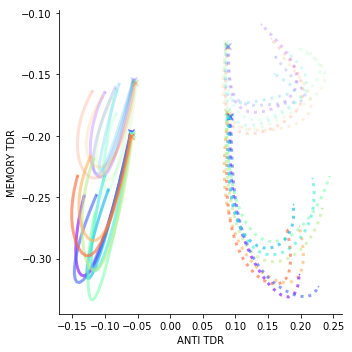

In [61]:
use_yinds = [0,1]
axes_label1 = Y_labels[use_yinds[0]]
axes_label2 = Y_labels[use_yinds[1]]
D_use = Beta_qr[:,use_yinds]

fig = plt.figure(figsize=(5,5),tight_layout=True,facecolor='white')
lim = .6
plot_FP = False
for ri in range(len(task_list)):
    ax1 = plt.subplot(1,1,1)
    
    if ri%2==0:
        linestyle = '-'
    else:
        linestyle = ':'
        
    if ri<2:
        al = .2
    else:
        al = .6
    
    rule_in = task_list[ri]
    if plot_FP==False:
        
        plot_N_jitter(m,D_use,rule_in,fp_epoch,rand_step_coef = 0,n_steps = 0,n_jit = 0,
                   lw = 3,al = al,linestyle = linestyle)
        tit_fp = 'woFP_'
    else:
    
        f = os.path.join(m_all,'tf_fixed_pts_all_init',rule_in,fp_epoch+'_'+str(fp_t_num[ri])+'.0.npz')
        fp_struct = np.load(f)
        sorted_fps = fp_struct['xstar']
        fp_inds = range(len(sorted_fps))
        plot_FP_jitter(m_all,D_use,rule_in,t_num,fp_epoch,sorted_fps,fp_inds,[rule_in,],
                   rand_step_coef = rand_step_coef, al = al, linestyle = linestyle, n_steps = 30, n_jit = 10)
        tit_fp = 'wFP_'
    
    ax1.spines['right'].set_visible(False)
    ax1.spines['top'].set_visible(False)
    plt.xlabel(axes_label1+ ' TDR')
    plt.ylabel(axes_label2+ ' TDR')
#     plt.ylim((-lim,lim))
#     plt.xlim((-lim,lim))

figpath = os.path.join(p,'code','overleaf','task_schematic_multitask','figs','interp_fps',dir_specific,str(model_n))
if not os.path.exists(figpath):
    os.makedirs(figpath)
tit = '4_task_'+axes_label1+'_'+axes_label2
figname = fp_epoch+'_'+tit+'.pdf'
plt.savefig(os.path.join(figpath,figname))
figname = fp_epoch+'_'+tit+'.png'
plt.savefig(os.path.join(figpath,figname))
plt.show()

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/softplus/l2w00001/0/ckpts/model.ckpt-401000


/Users/lauradriscoll/anaconda2/envs/tensorflow/lib/python2.7/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


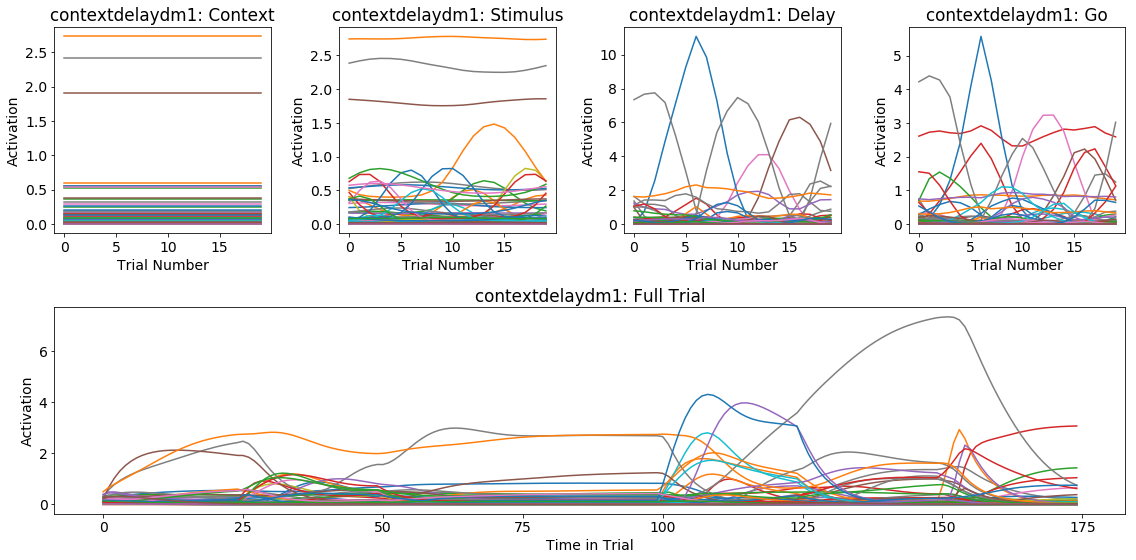

In [9]:
# Maybe useful [super basic] hidden unit activity visualization?
model_n = 0
model = Model(model_dir_all)
with tf.Session() as sess:

    ckpt_n = name_best_ckpt(model_dir_all,rule)
    ckpt_n_dir = os.path.join(model_dir_all,'ckpts/model.ckpt-' + str(int(ckpt_n)))
    model.saver.restore(sess,ckpt_n_dir)
    var_list = model.var_list
    params = [sess.run(var) for var in var_list]
    hparams = model.hp
    trial = generate_trials(rule, hparams, mode='test', noise_on=False, delay_fac =1)
    feed_dict = tools.gen_feed_dict(model, trial, hparams)
    h_tf = sess.run(model.h, feed_dict=feed_dict) #(n_time, n_condition, n_neuron)
        
fig = plt.figure(figsize=(16, 8),tight_layout=True,facecolor='white')
plt.rcParams.update({'font.size': 14})

ax1 = plt.subplot(2,4,1)
plt.plot(h_tf[trial.epochs['stim1'][0]-1,0:-1:16,:]) # Every other trial to exclude modality 2
plt.title(rule + ': Context')
plt.xlabel('Trial Number')
plt.ylabel('Activation')

ax1 = plt.subplot(2,4,2)
plt.plot(h_tf[trial.epochs['stim1'][0]+1,0:-1:16,:])
plt.title(rule + ': Stimulus')
plt.xlabel('Trial Number')
plt.ylabel('Activation')

ax1 = plt.subplot(2,4,3)
plt.plot(h_tf[trial.epochs['go1'][0]-1,0:-1:16,:])
plt.title(rule + ': Delay')
plt.xlabel('Trial Number')
plt.ylabel('Activation')

ax1 = plt.subplot(2,4,4)
plt.plot(h_tf[trial.epochs['go1'][0]+10,0:-1:16,:])
plt.title(rule + ': Go')
plt.xlabel('Trial Number')
plt.ylabel('Activation')

ax1 = plt.subplot(2,1,2)
plt.plot(h_tf[:,1,:])
plt.title(rule + ': Full Trial')
plt.xlabel('Time in Trial')
plt.ylabel('Activation')

plt.savefig('sfn/for_David/simple_trial_example.svg')
plt.show()

In [11]:
task_set = [13,14,15]

In [10]:
# Ok jumping into the meat of it- This code generates a list of hidden state activity 
# and input Jacobians for the different tasks. 
n_tasks = len(task_set)
n_total_trials = 400 # num trials in delaygo task
n_trials_use = 8
skip_trials = int(n_total_trials/n_trials_use)
#mod1 and mod2 are every other trial so we grab 8 trials from both groups spanning 360 stim angles
trial_set = np.concatenate((range(0,n_total_trials,skip_trials),range(1,n_total_trials,skip_trials)))
n_steps_early = 5
n_stim_dims = np.shape(trial.x)[2]-20
model_n = 0
# model_dir_all = os.path.join(p,'data/networks_for_david/',dir_specific,str(model_n))
model_dir_all = os.path.join(p,'data/rnn/multitask/crystals/highd_inputs/contextdm1_contextdm2/softplus/',dir_specific,str(model_n))
model_dir_all = os.path.join(p,'data/rnn/multitask/crystals/softplus/',dir_specific,str(model_n))
rule = 'delaygo'

def make_h_and_Jac(model_dir_all):
    
    h_context_combined = []
    h_stim_early_combined = []
    h_stim_late_combined = []
    
    model = Model(model_dir_all)
    with tf.Session() as sess:

        ckpt_n = name_best_ckpt(model_dir_all,rule)
        ckpt_n_dir = os.path.join(model_dir_all,'ckpts/model.ckpt-' + str(int(ckpt_n)))
        model.saver.restore(sess,ckpt_n_dir)
        # get all connection weights and biases as tensorflow variables
        var_list = model.var_list
        # evaluate the parameters after training
        params = [sess.run(var) for var in var_list]
        # get hparams
        hparams = model.hp
        trial = generate_trials('delaygo', hparams, mode='test', noise_on=False, delay_fac =1)
        
        #get size of relevant variables to init mats
        n_inputs = np.shape(trial.x)[2]
        N = np.shape(params[0])[1]
        #change this depending on when in the trial you're looking [must be a transition btwn epochs]
        time_set = [trial.epochs['stim1'][0]] #beginning of stim period

        #init mats
        J_np_u = np.zeros((n_tasks,len(trial_set),len(time_set),N,n_inputs))
        J_np_u_dot_delu = np.zeros((n_tasks,len(trial_set),len(time_set),N))

        for r in range(n_tasks):
            r_all_tasks_ind = task_set[r]
            
            trial.x[:,:,n_stim_dims:] = 0 #set all tasks to 0 #(n_time, n_trials, n_inputs)
            trial.x[:,:,n_stim_dims+r_all_tasks_ind] = 1 #except for this task
            
            feed_dict = tools.gen_feed_dict(model, trial, hparams)
            h_tf = sess.run(model.h, feed_dict=feed_dict) #(n_time, n_trials, n_neuron)

            # comparing Jacobians to proximity of hidden state across tasks
            # we focus on end of the context period, early, and late in the stim period
            h_context = np.reshape(h_tf[trial.epochs['stim1'][0]-1,trial_set,:],(1,-1)) # h @ end of context period
            h_stim_early = np.reshape(h_tf[trial.epochs['stim1'][0]+n_steps_early,trial_set,:],(1,-1)) # h @ 5 steps into stim
            h_stim_late = np.reshape(h_tf[trial.epochs['stim1'][1],trial_set,:],(1,-1)) # h @ end of stim period

            #concatenate activity states across tasks
            if h_context_combined == []:
                h_context_combined = h_context[np.newaxis,:]
                h_stim_late_combined = h_stim_late[np.newaxis,:]
                h_stim_early_combined = h_stim_early[np.newaxis,:]
            else:
                h_context_combined = np.concatenate((h_context_combined, h_context[np.newaxis,:]), axis=0)
                h_stim_late_combined = np.concatenate((h_stim_late_combined, h_stim_late[np.newaxis,:]), axis=0)
                h_stim_early_combined = np.concatenate((h_stim_early_combined, h_stim_early[np.newaxis,:]), axis=0)

            for trial_i in range(len(trial_set)): #depending on the analysis I was including one or many trials
                for time_i in range(len(time_set)): #also including one or many time pts

                    inputs = np.squeeze(trial.x[time_set[time_i],trial_set[trial_i],:]) #(n_time, n_condition, n_inputs)
                    inputs = inputs[np.newaxis,:]

                    states = h_tf[time_set[time_i],trial_set[trial_i],:]
                    states = states[np.newaxis,:]
                    
                    #calc Jac wrt inputs
                    inputs_context = np.squeeze(trial.x[time_set[time_i]-1,trial_set[trial_i],:]) #(n_time, n_condition, n_inputs)
                    inputs_context = inputs_context[np.newaxis,:]
                    delta_inputs = inputs - inputs_context

                    inputs_tf_context = tf.constant(inputs_context, dtype=tf.float32)
                    states_tf = tf.constant(states, dtype=tf.float32)
                    output, new_states = model.cell(inputs_tf_context, states_tf)
                    F_context = new_states

                    J_tf_u = pfor.batch_jacobian(F_context, inputs_tf_context, use_pfor=False)
                    J_np_u[r,trial_i,time_i,:,:] = sess.run(J_tf_u)
                    J_np_u_dot_delu[r,trial_i,time_i,:] = np.squeeze(np.dot(J_np_u[r,trial_i,time_i,:,:],delta_inputs.T))
                    
    return J_np_u_dot_delu, h_context_combined, h_stim_late_combined, h_stim_early_combined

In [11]:
def do_MDS(X_in):
    X = np.squeeze(X_in).astype(np.float64)
    row_means = np.mean(X, axis=0)
    X_center = X - np.tile(row_means,(X.shape[0],1))
    embedding = MDS(n_components=2)
    X_out = embedding.fit_transform(X_center)
    return X_out

def plot_MDS_tasks(X_out):
    plt.plot(X_out[:,0],X_out[:,1],'o')
    for r in range(len(X_out)):
        rule = rule_set_names[r]
        plt.text(X_out[r,0]*1.01,X_out[r,1]*1.01,rule)
    plt.box(False)
    plt.tick_params(top='off', bottom='off', left='off', right='off', labelleft='off', labelbottom='off')

In [12]:
fldr = os.path.join('sfn/for_David/')
if not os.path.exists(fldr):
    os.makedirs(fldr)

In [15]:
J_np_u_dot_delu, _, _, _ = make_h_and_Jac(model_dir_all)

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/softplus/l2w00001/0/ckpts/model.ckpt-389000


/Users/lauradriscoll/anaconda2/envs/tensorflow/lib/python2.7/site-packages/ipykernel_launcher.py:63: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.


In [16]:
r_set

NameError: name 'r_set' is not defined

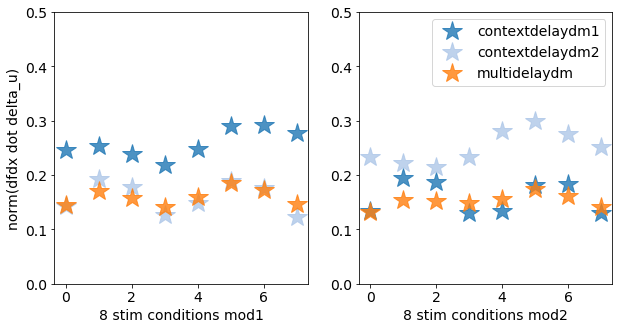

In [19]:
r_set = range(len(task_set))
cmap=plt.get_cmap('tab20')

fig = plt.figure(figsize=(10, 5))
plt.rcParams.update({'font.size': 14})
plt.subplot(1,2,1)
for stim1 in range(8):
    for r in r_set:
        c = cmap(r/20)
        if stim1 == 0:
            plt.subplot(1,2,1)
            plt.plot(stim1,LA.norm(J_np_u_dot_delu[r,stim1,:,:]),'*',markersize = 20,alpha = .8, c = c,label = rules_dict['all'][task_set[r]])
            plt.subplot(1,2,2)
            plt.plot(stim1,LA.norm(J_np_u_dot_delu[r,stim1+8,:,:]),'*',markersize = 20,alpha = .8, c = c,label = rules_dict['all'][task_set[r]])
        else:
            plt.subplot(1,2,1)
            plt.plot(stim1,LA.norm(J_np_u_dot_delu[r,stim1,:,:]),'*',markersize = 20,alpha = .8, c = c)
            plt.subplot(1,2,2)
            plt.plot(stim1,LA.norm(J_np_u_dot_delu[r,stim1+8,:,:]),'*',markersize = 20,alpha = .8, c = c)

plt.subplot(1,2,1)
plt.xlabel('8 stim conditions mod1')
plt.ylabel('norm(dfdx dot delta_u)')
plt.ylim((0,.5))

plt.subplot(1,2,2)
plt.xlabel('8 stim conditions mod2')
plt.ylim((0,.5))

plt.legend()
plt.show()

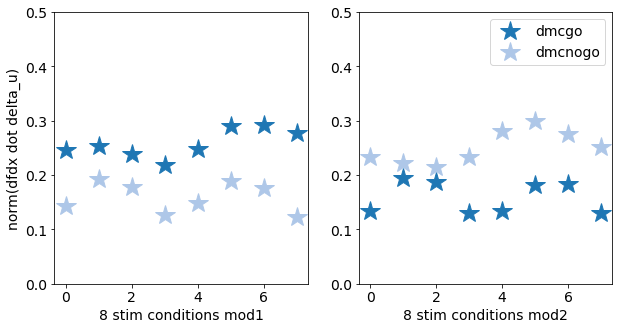

In [20]:
r_set = range(2)
cmap=plt.get_cmap('tab20')

fig = plt.figure(figsize=(10, 5))
plt.rcParams.update({'font.size': 14})
plt.subplot(1,2,1)
for stim1 in range(8):
    for r in r_set:
        c = cmap(r/20)
        if stim1 == 0:
            plt.subplot(1,2,1)
            plt.plot(stim1,LA.norm(J_np_u_dot_delu[r,stim1,:,:]),'*',markersize = 20,alpha = 1, c = c,label = rule_set[task_set[r]])
            plt.subplot(1,2,2)
            plt.plot(stim1,LA.norm(J_np_u_dot_delu[r,stim1+8,:,:]),'*',markersize = 20,alpha = 1, c = c,label = rule_set[task_set[r]])
        else:
            plt.subplot(1,2,1)
            plt.plot(stim1,LA.norm(J_np_u_dot_delu[r,stim1,:,:]),'*',markersize = 20,alpha = 1, c = c)
            plt.subplot(1,2,2)
            plt.plot(stim1,LA.norm(J_np_u_dot_delu[r,stim1+8,:,:]),'*',markersize = 20,alpha = 1, c = c)

plt.subplot(1,2,1)
plt.xlabel('8 stim conditions mod1')
plt.ylabel('norm(dfdx dot delta_u)')
plt.ylim((0,.5))

plt.subplot(1,2,2)
plt.xlabel('8 stim conditions mod2')
plt.ylim((0,.5))

plt.legend()
plt.show()

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/networks_for_david/l2w0001/0/ckpts/model.ckpt-270000


/Users/lauradriscoll/anaconda2/envs/tensorflow/lib/python2.7/site-packages/ipykernel_launcher.py:60: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
/Users/lauradriscoll/anaconda2/envs/tensorflow/lib/python2.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


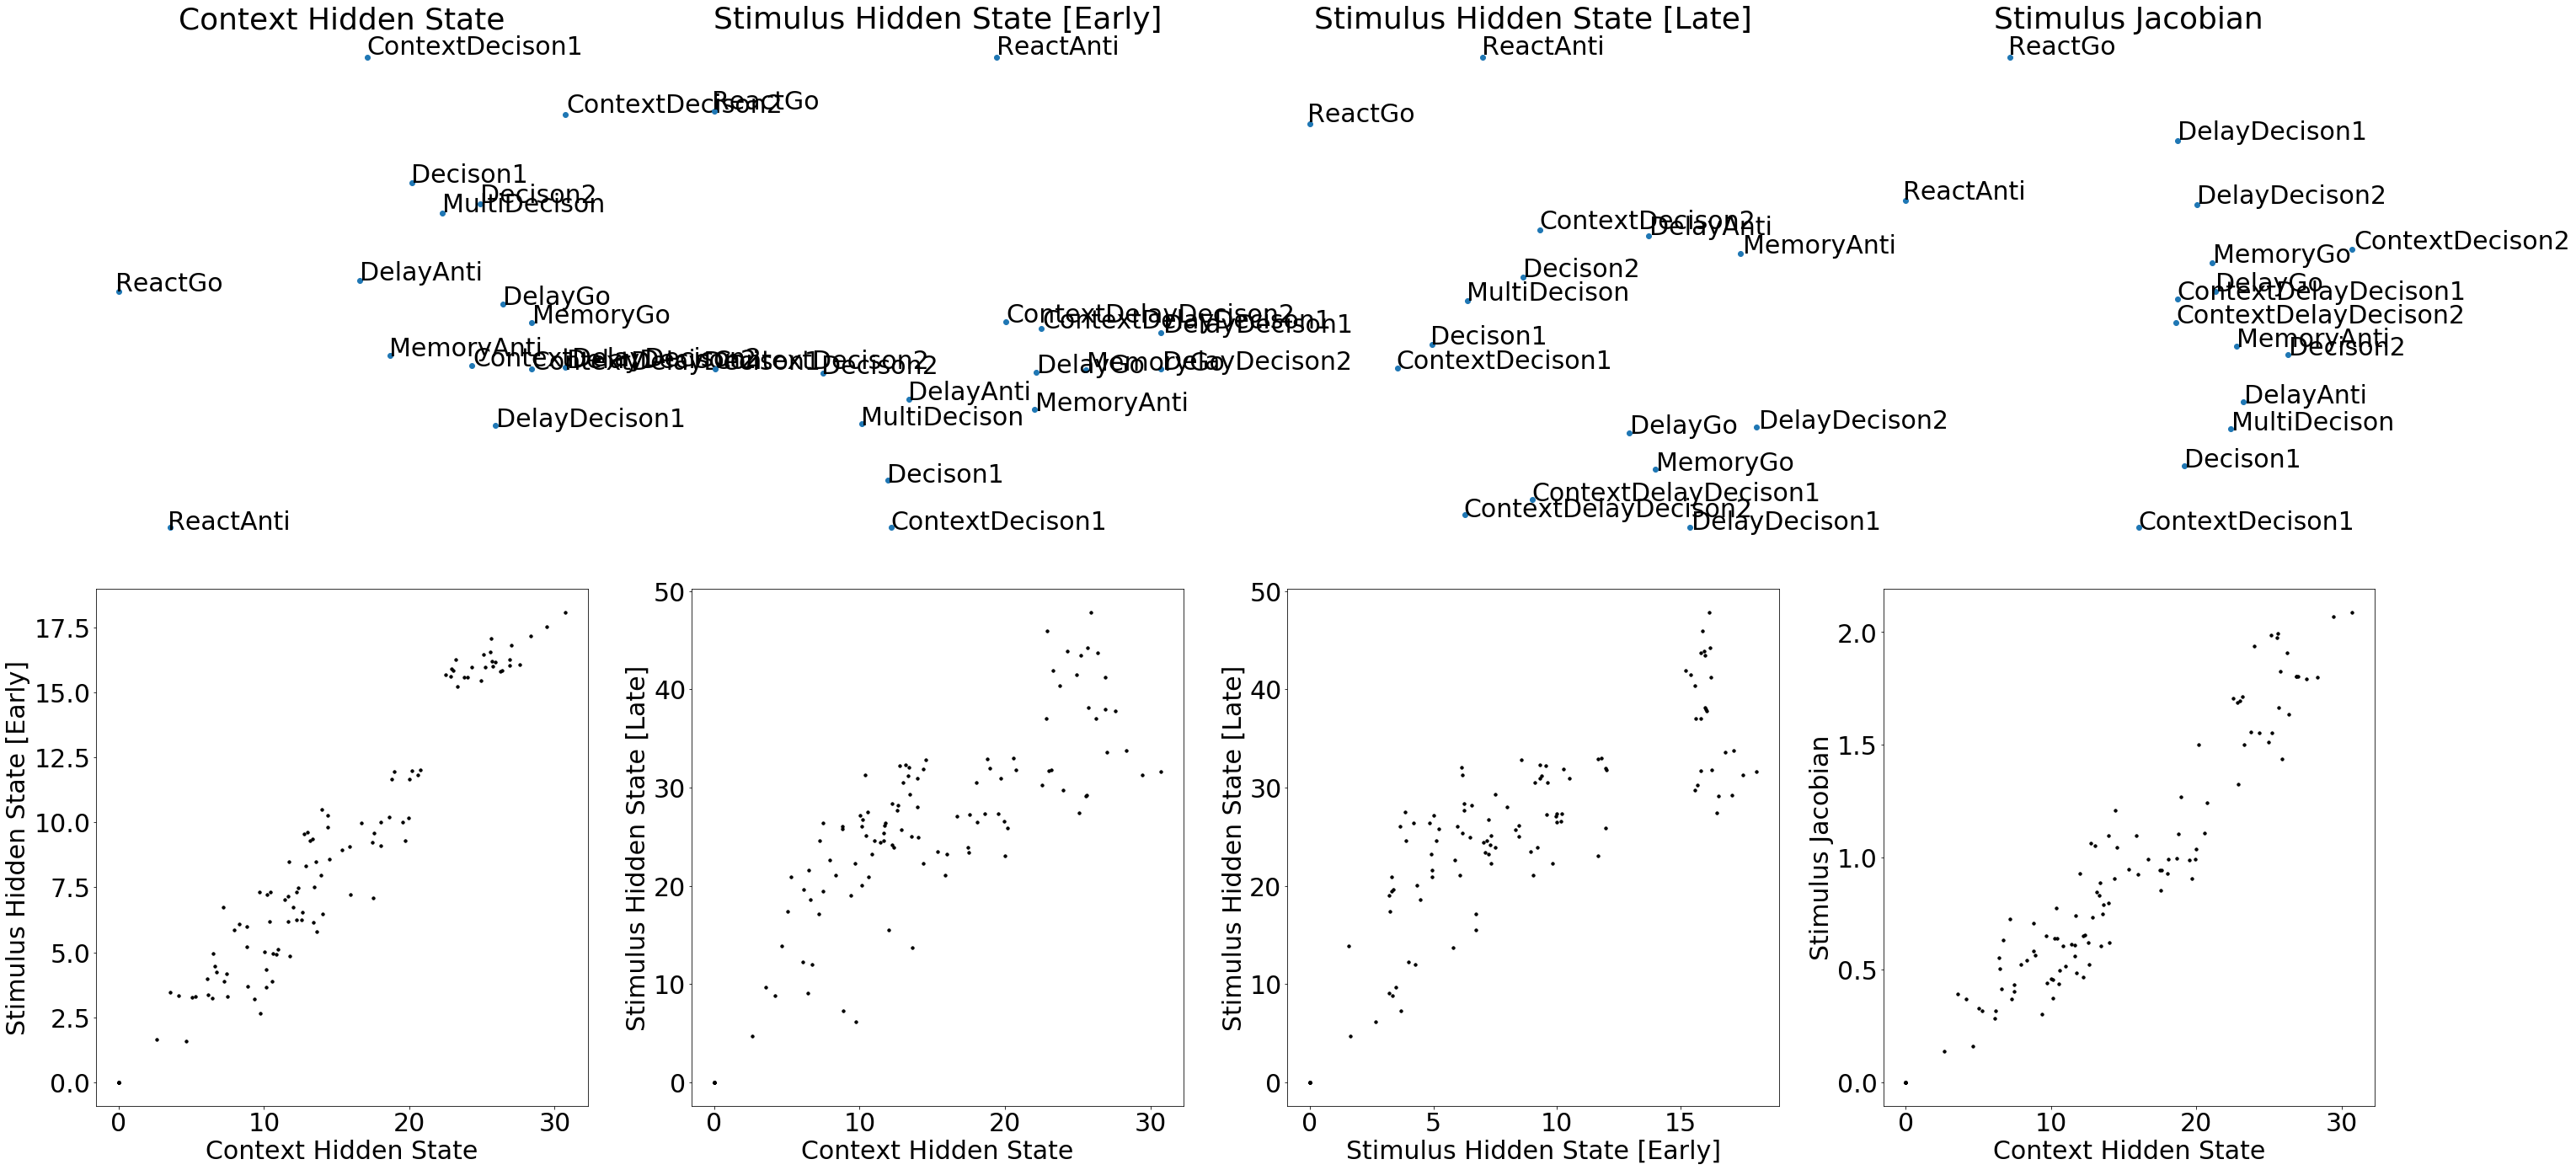

In [52]:
model_dir_all = os.path.join(p,'data/networks_for_david/',dir_specific,str(model_n))
J_np_u_dot_delu, h_context_combined, h_stim_late_combined, h_stim_early_combined = make_h_and_Jac(model_dir_all)

# Distances across different tasks
dist = DistanceMetric.get_metric('euclidean')
X_euc_context = dist.pairwise(np.squeeze(h_context_combined))
X_euc_stim_early = dist.pairwise(np.squeeze(h_stim_early_combined-h_context_combined))
X_euc_stim_late = dist.pairwise(np.squeeze(h_stim_late_combined-h_context_combined))
X_euc_stim_Jac = dist.pairwise(np.reshape(np.squeeze(J_np_u_dot_delu),(n_tasks,-1)))

# MDS for each metric
X_context = do_MDS(h_context_combined)
X_del_stim_early = do_MDS(h_stim_early_combined-h_context_combined)
X_del_stim_late = do_MDS(h_stim_late_combined-h_context_combined)
X_stim_Jac = do_MDS(np.reshape(np.squeeze(J_np_u_dot_delu),(n_tasks,-1)))

fig = plt.figure(figsize=(40, 20),tight_layout=True,facecolor='white')
plt.rcParams.update({'font.size': 30})

ax1 = plt.subplot(2,4,1)
plot_MDS_tasks(X_context)
plt.title('Context Hidden State')

ax2 = plt.subplot(2,4,2)
plot_MDS_tasks(X_del_stim_early)
plt.title('Stimulus Hidden State [Early]')

ax2 = plt.subplot(2,4,3)
plot_MDS_tasks(X_del_stim_late)
plt.title('Stimulus Hidden State [Late]')

ax2 = plt.subplot(2,4,4)
plot_MDS_tasks(X_stim_Jac)
plt.title('Stimulus Jacobian')

ax3 = plt.subplot(2,4,5)
plt.plot(X_euc_context[:],X_euc_stim_early[:],'.k')
plt.xlabel('Context Hidden State')
plt.ylabel('Stimulus Hidden State [Early]')

ax3 = plt.subplot(2,4,6)
plt.plot(X_euc_context[:],X_euc_stim_late[:],'.k')
plt.xlabel('Context Hidden State')
plt.ylabel('Stimulus Hidden State [Late]')

ax3 = plt.subplot(2,4,7)
plt.plot(X_euc_stim_early[:],X_euc_stim_late[:],'.k')
plt.xlabel('Stimulus Hidden State [Early]')
plt.ylabel('Stimulus Hidden State [Late]')

ax3 = plt.subplot(2,4,8)
plt.plot(X_euc_context[:],X_euc_stim_Jac[:],'.k')
plt.xlabel('Context Hidden State')
plt.ylabel('Stimulus Jacobian')

plt.show()

In [23]:
X_euc_context_all = {}
X_euc_stim_early_all = {}
X_euc_stim_late_all = {}
X_euc_stim_Jac_all = {}

model_n = 0

for d in range(len(dir_set)):
    dir_specific = dir_set[d]
    model_dir_all = os.path.join(p,'data/networks_for_david/',dir_specific,str(model_n))
    J_np_u_dot_delu, h_context_combined, h_stim_late_combined, h_stim_early_combined = make_h_and_Jac(model_dir_all)

    # Distances across different tasks
    dist = DistanceMetric.get_metric('euclidean')
    X_euc_context = dist.pairwise(np.squeeze(h_context_combined))
    X_euc_stim_early = dist.pairwise(np.squeeze(h_stim_early_combined-h_context_combined))
    X_euc_stim_late = dist.pairwise(np.squeeze(h_stim_late_combined-h_context_combined))
    X_euc_stim_Jac = dist.pairwise(np.reshape(np.squeeze(J_np_u_dot_delu),(n_tasks,-1)))

    # MDS for each metric
    X_context = do_MDS(h_context_combined)
    X_del_stim_early = do_MDS(h_stim_early_combined-h_context_combined)
    X_del_stim_late = do_MDS(h_stim_late_combined-h_context_combined)
    X_stim_Jac = do_MDS(np.reshape(np.squeeze(J_np_u_dot_delu),(n_tasks,-1)))

    X_euc_context_all[dir_specific] = X_euc_context
    X_euc_stim_early_all[dir_specific] = X_euc_stim_early
    X_euc_stim_late_all[dir_specific] = X_euc_stim_late
    X_euc_stim_Jac_all[dir_specific] = X_euc_stim_Jac

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/networks_for_david/no_reg/0/ckpts/model.ckpt-389000


/Users/lauradriscoll/anaconda2/envs/tensorflow/lib/python2.7/site-packages/ipykernel_launcher.py:60: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.


Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/networks_for_david/l2h00001/0/ckpts/model.ckpt-462000
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/networks_for_david/l2w0001/0/ckpts/model.ckpt-270000


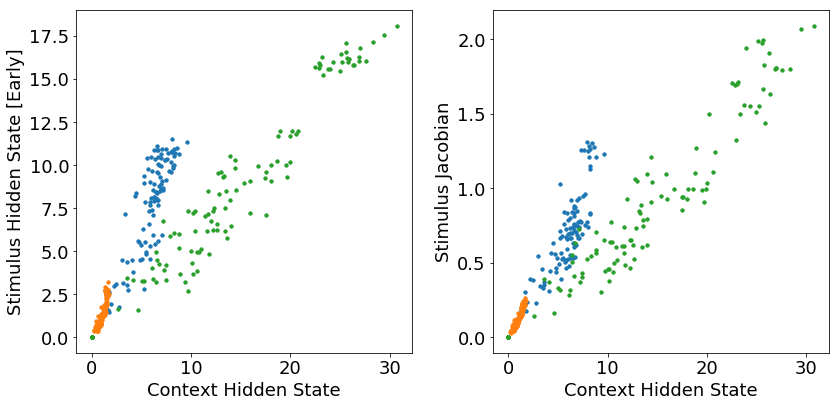

In [24]:
fig = plt.figure(figsize=(12, 6),tight_layout=True,facecolor='white')
plt.rcParams.update({'font.size': 18})

dir_set = ['no_reg','l2h00001','l2w0001'] 
cmap = plt.cm.get_cmap('tab10')

for ii in range(3):
    d = dir_set[ii]
    c = cmap(ii/10)
    ax3 = plt.subplot(1,2,1)
    plt.plot(X_euc_context_all[d][:],X_euc_stim_early_all[d][:],'.',c=c)
    plt.xlabel('Context Hidden State')
    plt.ylabel('Stimulus Hidden State [Early]')

    ax3 = plt.subplot(1,2,2)
    plt.plot(X_euc_context_all[d][:],X_euc_stim_Jac_all[d][:],'.',c=c)
    plt.xlabel('Context Hidden State')
    plt.ylabel('Stimulus Jacobian')

plt.show()

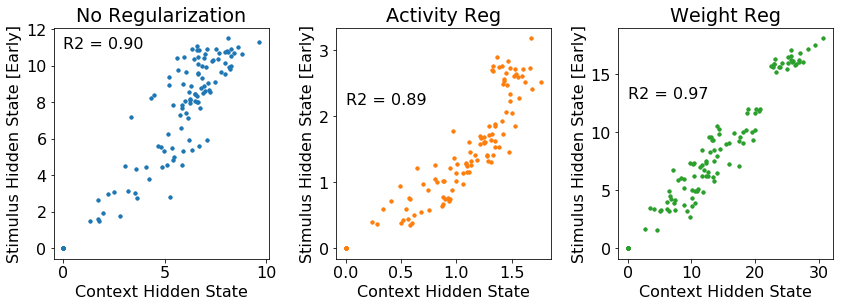

In [25]:
import scipy


fig = plt.figure(figsize=(12, 8),tight_layout=True,facecolor='white')
plt.rcParams.update({'font.size': 16})

dir_set = ['no_reg','l2h00001','l2w0001']
labels = ['No Regularization','Activity Reg','Weight Reg']
cmap = plt.cm.get_cmap('tab10')

for ii in range(3):
    d = dir_set[ii]
    c = cmap(ii/10)
    t = labels[ii]

    ax3 = plt.subplot(2,3,ii+1)
    
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(X_euc_context_all[d].flatten(), X_euc_stim_early_all[d].flatten())
    plt.plot(X_euc_context_all[d].flatten(),X_euc_stim_early_all[d].flatten(),'.',c=c)
    plt.xlabel('Context Hidden State')
    plt.ylabel('Stimulus Hidden State [Early]')
    plt.title(t)
    s = 'R2 = '+ "{:.2f}".format(r_value)
    plt.text(0,1.5*np.mean(X_euc_stim_early_all[d].flatten()),s)

    
plt.savefig('sfn/for_David/stim_v_context_and_jac.svg')
plt.show()

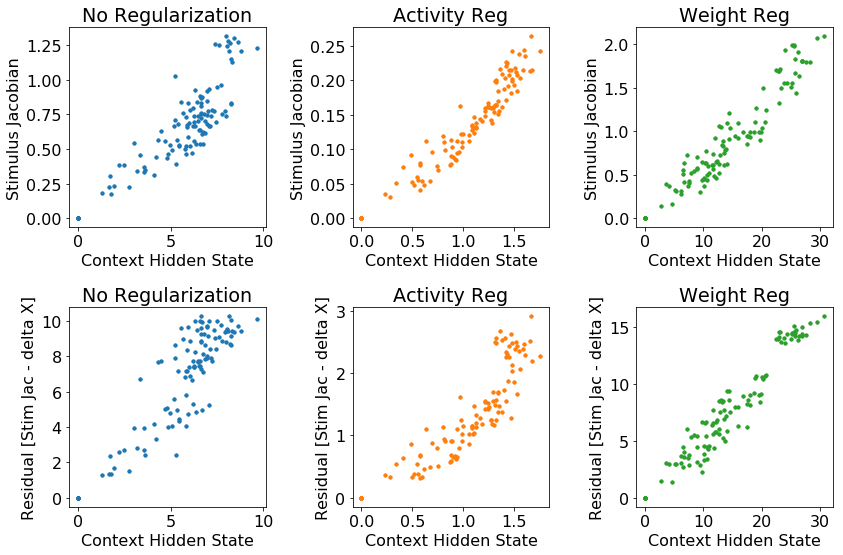

In [26]:
#Wanted to plot the difference between the stimulus jacobian and the actual update 
#but the scales are off so i don't think this analysis really makes sense.

fig = plt.figure(figsize=(12, 8),tight_layout=True,facecolor='white')
plt.rcParams.update({'font.size': 16})

dir_set = ['no_reg','l2h00001','l2w0001']
labels = ['No Regularization','Activity Reg','Weight Reg']
cmap = plt.cm.get_cmap('tab10')

for ii in range(3):
    d = dir_set[ii]
    c = cmap(ii/10)
    t = labels[ii]

    ax3 = plt.subplot(2,3,ii+1)
    plt.plot(X_euc_context_all[d][:],X_euc_stim_Jac_all[d][:],'.',c=c)
    plt.xlabel('Context Hidden State')
    plt.ylabel('Stimulus Jacobian')
    plt.title(t)

    ax3 = plt.subplot(2,3,ii+1+3)
    plt.plot(X_euc_context_all[d][:],X_euc_stim_early_all[d][:] - X_euc_stim_Jac_all[d][:],'.',c=c)
    plt.xlabel('Context Hidden State')
    plt.ylabel('Residual [Stim Jac - delta X]')
    plt.title(t)

    
plt.savefig('sfn/for_David/stim_v_context_and_residual.svg')
plt.show()

In [7]:
 ## JAX fixed point stuff
sys.path.append(os.path.join(p,'code','computation-thru-dynamics'))
import fixed_point_finder.decision as decision
import fixed_point_finder.fixed_points as fp_optimize
import fixed_point_finder.rnn as rnn
import fixed_point_finder.utils as utils

import h5py
import jax.numpy as np
from jax import jacrev, random, vmap
from jax.experimental import optimizers
from jax.ops import index, index_add, index_update
import numpy as onp             # original CPU-backed NumPy

model = Model(model_dir_all)
rule = 'delaygo'
with tf.Session() as sess:
    model.restore()
    # get all connection weights and biases as tensorflow variables
    var_list = model.var_list
    # evaluate the parameters after training
    params = [sess.run(var) for var in var_list]
    # get hparams
    hparams = model.hp
    # create a trial
    trial = generate_trials(rule, hparams, mode='random', noise_on=False, batch_size =1000, delay_fac =1)
    # get feed_dict
    feed_dict = tools.gen_feed_dict(model, trial, hparams)
    # run model
    h_tf, y_hat_tf = sess.run([model.h, model.y_hat], feed_dict=feed_dict) #(n_time, n_condition, n_neuron)

    n_input = hparams['n_input']
    n_rnn = hparams['n_rnn']
    n_output = hparams['n_output']
    w_in = params[0]
    b_in = params[1]
    w_out = params[2]
    b_out = params[3]
    sigma_rec = hparams['sigma_rec']
    dt = hparams['dt']
    tau = hparams['tau']
    alpha = dt/tau
    activation = hparams['activation']

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
Instructions for updating:
Use `tf.global_variables_initializer` instead.
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/networks_for_david/l2w0001/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/networks_for_david/l2w0001/0/model.ckpt


In [8]:
if activation == 'softplus':
    _activation = lambda x: np.log(np.exp(x) + 1)
elif activation == 'tanh':
    _activation = lambda x: np.tanh(x)
elif activation == 'relu':
    _activation = lambda x: x * (x > 0)
elif activation == 'power':
    _activation = lambda x: (x * (x > 0))**2
elif activation == 'retanh':
    _activation = lambda x: np.tanh(x * (x > 0))

def out_affine(params, h):
    return np.dot(params[2].T,h)+params[3]

def relu(x):
    f = x * (x > 0)
    return f

def rnn_vanilla(params, h, x):
    xh = np.concatenate([x,h], axis=0)
    gate_inputs = np.dot(params[0].T,xh)+params[1]
    noise = 0
    output = _activation(gate_inputs) # + noise

    h_new = (1-alpha) * h + alpha * output
    
    return h_new

def vanilla_run_with_h0(params, x_t, h0):
    h = h0
    h_t = []
    h_t.append(h)
    for x in x_t:
        h = rnn_vanilla(params, np.squeeze(h), np.squeeze(x.T))
        h_t.append(np.expand_dims(h,axis=1))

    h_t = np.squeeze(np.array(h_t))  
    o_t = batch_affine(params, h_t)
    return h_t, o_t

def generate_Beta_epoch(h_tf,trial):
    Beta_epoch1 = {}
    Beta_epoch2 = {}

    for epoch in trial.epochs.keys():
        T_use = trial.epochs[epoch][1], 
        if T_use[0] is None:
            T_use = np.shape(trial.x)
            
        inds_use = trial.stim_strength[:,0]>.99
        X = h_tf[T_use[0]-1,inds_use,:].T
        X_zscore = stats.zscore(X, axis=1)
        X_zscore_nonan = X_zscore
        X_zscore_nonan[np.isnan(X_zscore)] = 0
        r = X_zscore_nonan

        y1 = np.sin(trial.stim_locs[inds_use,0:1])
        y2 = np.cos(trial.stim_locs[inds_use,0:1])
        y = onp.concatenate((y1,y2),axis=1)

        lm = linear_model.LinearRegression()
        model = lm.fit(y,r.T)
        Beta = model.coef_
        Beta_epoch1[epoch],_ = LA.qr(Beta)

        inds_use = trial.stim_strength[:,1]>.99
        X = h_tf[T_use[0]-1,inds_use,:].T
        X_zscore = stats.zscore(X, axis=1)
        X_zscore_nonan = X_zscore
        X_zscore_nonan[np.isnan(X_zscore)] = 0
        r = X_zscore_nonan
        
        y1 = np.sin(trial.stim_locs[inds_use,1:2])
        y2 = np.cos(trial.stim_locs[inds_use,1:2])
        y = onp.concatenate((y1,y2),axis=1)

        lm = linear_model.LinearRegression()
        model = lm.fit(y,r.T)
        Beta = model.coef_
        Beta_epoch2[epoch],_ = LA.qr(Beta)

    return Beta_epoch1, Beta_epoch2

In [124]:
rule = 'delaygo'
fp_epoch = 'delay1'

model = Model(model_dir_all)
with tf.Session() as sess:
    model.restore()
    hparams = model.hp
    trial = generate_trials(rule, hparams, mode='test', noise_on=False, batch_size = 128, delay_fac =1)
    feed_dict = tools.gen_feed_dict(model, trial, hparams)
    h_tf, y_hat_tf = sess.run([model.h, model.y_hat], feed_dict=feed_dict) #(n_time, n_condition, n_neuron)

# get trial shape
_,B,N = np.shape(h_tf)
trial_set = range(0,B,int(B/100))
trial_set = range(B)

# Fixed point epoch
T = trial.epochs[fp_epoch][1]

# Input during fixed point epoch
x_star = trial.x[T-1,0,:]  

# Make a one parameter function of thie hidden state, useful for jacobians.
rnn_fun = lambda h : rnn_vanilla(params, h, x_star)
batch_rnn_fun = vmap(rnn_fun, in_axes=(0,))

fp_candidates = np.transpose(h_tf,(1,0,2))  # was batch x time x dim
a = np.reshape(fp_candidates[range(0,10),trial.epochs['fix1'][1],:], (-1, N)) # now batch * time x dim
b = np.reshape(fp_candidates[trial_set,T-1:T,:], (-1, N)) # now batch * time x dim
fp_candidates = np.concatenate((a, b), axis=0)

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/networks_for_david/l2w0001/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/networks_for_david/l2w0001/0/model.ckpt


In [125]:
fp_loss_fun = fp_optimize.get_fp_loss_fun(rnn_fun)
total_fp_loss_fun = fp_optimize.get_total_fp_loss_fun(rnn_fun)

# Fixed point optimization hyperparameters
fp_num_batches = 10000       # Total number of batches to train on.
fp_batch_size = 128          # How many examples in each batch
fp_step_size = 0.2           # initial learning rate
fp_decay_factor = 0.9999     # decay the learning rate this much
fp_decay_steps = 1           #
fp_adam_b1 = 0.9             # Adam parameters
fp_adam_b2 = 0.999
fp_adam_eps = 1e-5
fp_opt_print_every = 100   # Print training information during optimziation every so often

# Fixed point finding thresholds and other HPs
fp_noise_var = 0.0001      # Gaussian noise added to fixed point candidates before optimization.
fp_opt_stop_tol = 0.000001  # Stop optimizing when the average value of the batch is below this value.
fp_tol = 0.000001        # Discard fps with squared speed larger than this value.
fp_unique_tol = 0.025   # tolerance for determination of identical fixed points
fp_outlier_tol = 1.0    # Anypoint whos closest fixed point is greater than tol is an outlier.

In [126]:
reload(fp_optimize)

fp_tols = [0.000001, 0.00000005, 0.00000002] # Used for both fp_tol and opt_stop_tol

all_fps = {}
for tol in fp_tols:
    fp_hps = {'num_batches' : fp_num_batches, 
              'step_size' : fp_step_size, 
              'decay_factor' : fp_decay_factor, 
              'decay_steps' : fp_decay_steps, 
              'adam_b1' : fp_adam_b1, 'adam_b2' : fp_adam_b2, 'adam_eps' : fp_adam_eps,
              'noise_var' : fp_noise_var, 
              'fp_opt_stop_tol' : tol, 
              'fp_tol' : tol, 
              'unique_tol' : fp_unique_tol, 
              'outlier_tol' : fp_outlier_tol, 
              'opt_print_every' : fp_opt_print_every}
    fps, fp_losses, fp_idxs, fp_opt_details = \
        fp_optimize.find_fixed_points(rnn_fun, fp_candidates, fp_hps, do_print=True)
    if len(fp_idxs) > 0:
        F_of_fps = batch_rnn_fun(fps)
    else:
        F_of_fps = onp.zeros([0,N])
        
    all_fps[tol] = {'fps' : fps, 'candidates' : fp_candidates[fp_idxs],
                    'losses' : fp_losses, 'F_of_fps' : F_of_fps, 
                    'opt_details' : fp_opt_details, 'hps' : fp_hps}

    all_fps[tol]


Adding noise to fixed point candidates.
Optimizing to find fixed points.
    Batches 1-100 in 0.45 sec, Step size: 0.19801, Training loss 0.00000
Stopping as mean training loss 0.00000 is below tolerance 0.00000.
Excluding fixed points with squared speed above tolerance 0.00000.
    Kept 410/410 fixed points with tolerance under 0.000001.
Excluding non-unique fixed points.
    Kept 410/410 unique fixed points with uniqueness tolerance 0.025000.
Excluding outliers.
    Kept 410/410 fixed points with within outlier tolerance 1.000000.
Sorting fixed points slowest first.
Adding noise to fixed point candidates.
Optimizing to find fixed points.
    Batches 1-100 in 0.40 sec, Step size: 0.19801, Training loss 0.00000
Stopping as mean training loss 0.00000 is below tolerance 0.00000.
Excluding fixed points with squared speed above tolerance 0.00000.
    Kept 400/410 fixed points with tolerance under 0.000000.
Excluding non-unique fixed points.
    Kept 400/400 unique fixed points with uniquen

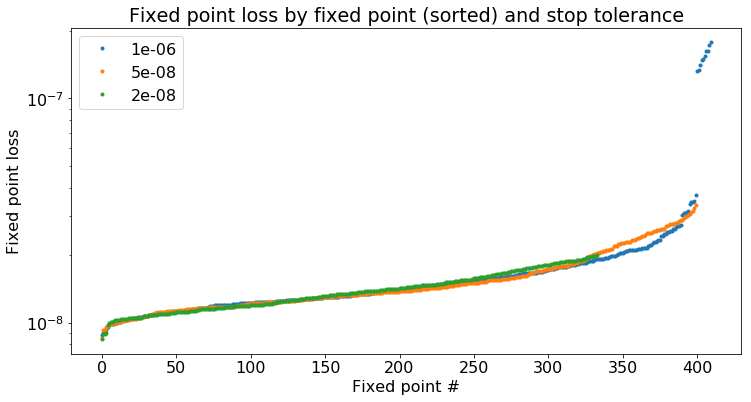

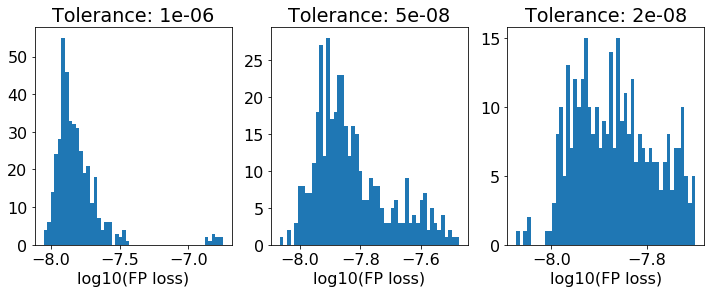

In [127]:
f1 = plt.figure(figsize=(12,6))

for tol in fp_tols: 
    plt.semilogy(all_fps[tol]['losses'],'.'); 
    plt.xlabel('Fixed point #')
    plt.ylabel('Fixed point loss');
plt.legend(fp_tols)
plt.title('Fixed point loss by fixed point (sorted) and stop tolerance')

f2 = plt.figure(figsize=(12,4))

pidx = 1
nfp_tols = len(fp_tols)
for tol_idx, tol in enumerate(fp_tols):
    plt.subplot(1, nfp_tols, pidx); pidx += 1
    plt.hist(onp.log10(fp_loss_fun(all_fps[tol]['fps'])), 50);
    plt.xlabel('log10(FP loss)')
    plt.title('Tolerance: ' + str(tol));

In [135]:
best_tol = fp_tols[2] #2 is the slowest fps

fps = all_fps[best_tol]['fps']
fp_readouts = onp.squeeze(onp.dot(params[2].T,fps.T)+onp.expand_dims(params[3], axis=1)) #readout before go will be zero

if np.shape(fps)[0]==1:
    sorted_fp_readouts = fp_readouts[1]
    sorted_fps = fps
    jacs = fp_optimize.compute_jacobians(rnn_fun, sorted_fps)
    eig_decomps = fp_optimize.compute_eigenvalue_decomposition(jacs, sort_by='real', do_compute_lefts=True)
    
else:
    fp_ro_sidxs = onp.argsort(fp_readouts[1,:])
    sorted_fp_readouts = fp_readouts[1,fp_ro_sidxs]
    sorted_fps = fps[fp_ro_sidxs]

    downsample_fps = 4 # Use this if too many fps
    sorted_fp_readouts = sorted_fp_readouts[0:-1:downsample_fps]
    sorted_fps = sorted_fps[0:-1:downsample_fps]
    jacs = fp_optimize.compute_jacobians(rnn_fun, sorted_fps)
    eig_decomps = fp_optimize.compute_eigenvalue_decomposition(jacs, sort_by='real', do_compute_lefts=True)

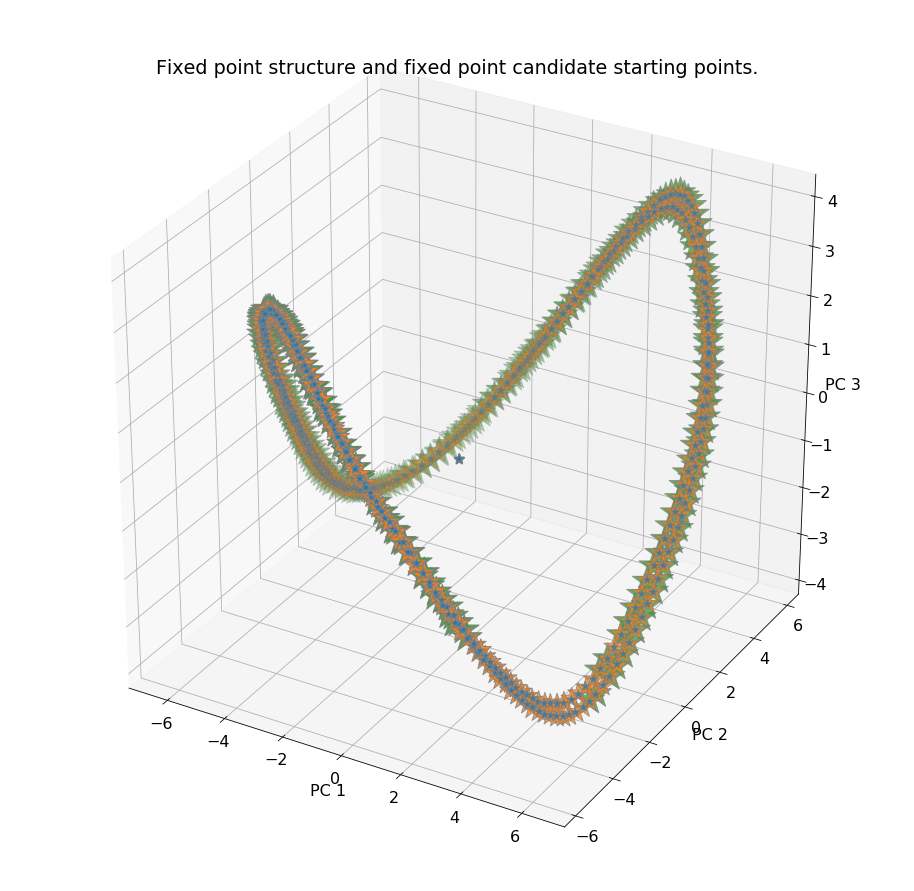

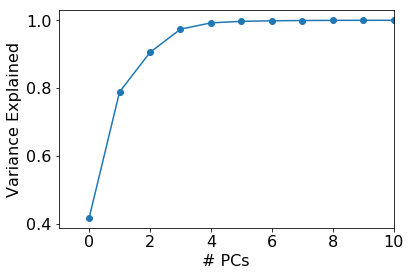

In [136]:
n=N
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
fig = plt.figure(figsize=(16,16));
ax = fig.add_subplot(111, projection='3d');

pca = PCA(n_components=30).fit(fp_candidates)

max_fps_to_plot = 1000
sizes = [100, 500, 1000]
for tol, size in zip(fp_tols[0:3], sizes):
    hiddens = all_fps[tol]['candidates']

    h_pca = pca.transform(hiddens)

    emax = h_pca.shape[0] if h_pca.shape[0] < max_fps_to_plot else max_fps_to_plot

    alpha = 0.01
    ax.scatter(h_pca[0:emax,0], h_pca[0:emax,1], h_pca[0:emax,2], color=[0, 0, 0, 0.1], s=10)

    hstars = np.reshape(all_fps[tol]['fps'], (-1, n))
    hstar_pca = pca.transform(hstars)
    
    marker_style = dict(marker='*', s=size, edgecolor='gray')
    
    ax.scatter(hstar_pca[0:emax,0], hstar_pca[0:emax,1], hstar_pca[0:emax,2], 
                'k', **marker_style);#c=color[0:emax], **marker_style);

    for eidx in range(emax):
        ax.plot3D([h_pca[eidx,0], hstar_pca[eidx,0]], 
                  [h_pca[eidx,1], hstar_pca[eidx,1]],
                  [h_pca[eidx,2], hstar_pca[eidx,2]], c=[0, 0, 1, alpha])    
        
plt.title('Fixed point structure and fixed point candidate starting points.');
ax.set_xlabel('PC 1')
ax.set_ylabel('PC 2')
ax.set_zlabel('PC 3')
plt.show()

plt.plot(onp.cumsum(pca.explained_variance_ratio_),'-o')
plt.xlim((-1,10))
plt.xlabel('# PCs')
plt.ylabel('Variance Explained')
plt.show()

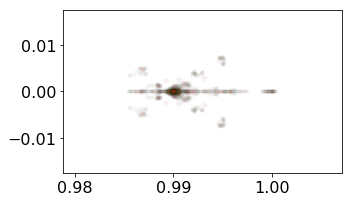

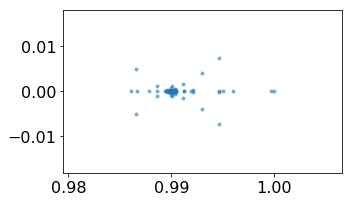

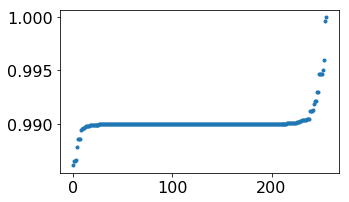

In [137]:
plt.figure(figsize=(5, 3))

for decomp in eig_decomps:
    plt.scatter(decomp['evals'].real, decomp['evals'].imag, marker = '.', alpha = .01)
plt.show()

plt.figure(figsize=(5, 3))
plt.scatter(decomp['evals'].real, decomp['evals'].imag, marker = '.', alpha = .5)
plt.show()

plt.figure(figsize=(5, 3))
plt.plot(onp.sort(decomp['evals'].real),'.')
plt.show()

In [177]:
# Everything is in the nullspace of the readout still so these vals will be close to zero
ldots = []
rdots = []
rdotla = []
del_x = trial.x[T,0,:] - trial.x[T-1,0,:] 

nfps = len(sorted_fps)
for jidx in range(nfps):
    fp = sorted_fps[jidx, :]
    rnn_fun_x = lambda x : rnn_vanilla(params, fp, onp.squeeze(x.T))
    dfdx = jacrev(rnn_fun_x)
    r0 = onp.real(eig_decomps[jidx]['R'][:,0])                          
    rdots.append(onp.dot(r0.T, params[2]))
    l0 = onp.real(eig_decomps[jidx]['L'][:,0])
    ldots.append(onp.dot(l0.T, dfdx(del_x)[:,:3]))

plt.figure(figsize=(12,4))
plt.subplot(121)
plt.scatter(sorted_fp_readouts, onp.abs(rdots)[:,1], c = 'k')
plt.title('Rights dotted with readout')
plt.subplot(122)
plt.scatter(sorted_fp_readouts, onp.abs(ldots)[:,1], c = 'k')
plt.title('Lefts dotted with effective input')
# plt.ylim([0, 3]);

Exception: Tracer can't be used with raw numpy functions. You might have
  import numpy as np
instead of
  import jax.numpy as np

In [156]:
def plot_FP(X, D, qvals):
    """Plot activity is some 2D space.

        Args:
            X: Fixed points in #Fps x Neurons
            D: Neurons x 2 plotting dims
    
        """
    log_qvals = np.log10(qvals)

    qmap=plt.get_cmap('gray')
    S = np.shape(X)[0]
    
    for s in range(S):
        c = 'k'
        X_trial = np.dot(X[s,:],D.T)
        plt.plot(X_trial[0],X_trial[1],'*',c = c)

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/networks_for_david/l2w0001/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/networks_for_david/l2w0001/0/model.ckpt


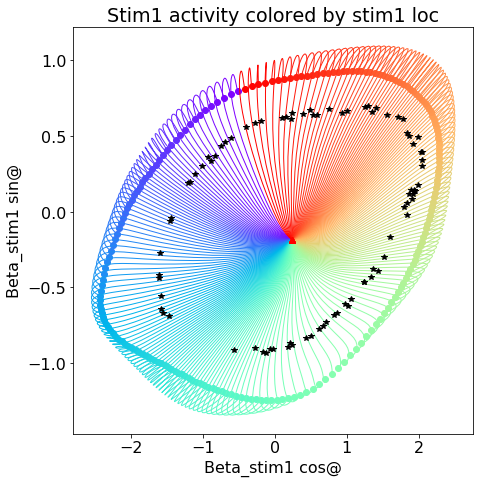

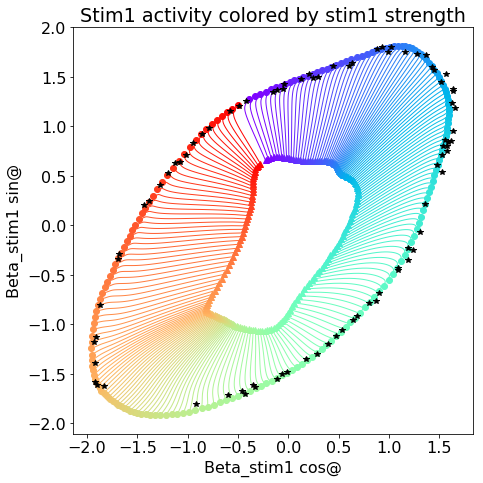

In [163]:
## do regression with random trials
e1 = 'stim1'
e2 = 'delay1'

T1_use = trial.epochs[e1][1]
T2_use = trial.epochs[e2][1]

inds_use1 = trial.stim_strength[:,0]>.99
stim1 = trial.stim_locs[inds_use1,0:1]
X = h_tf[T1_use,inds_use1,:].T
y1 = np.sin(stim1)
y2 = np.cos(stim1)
y = onp.concatenate((y1,y2),axis=1)

X_zscore = stats.zscore(X, axis=1)
X_zscore_nonan = X_zscore
X_zscore_nonan[np.isnan(X_zscore)] = 0
r = X_zscore_nonan

lm = linear_model.LinearRegression()
model = lm.fit(y,r.T)
Beta = model.coef_
Beta_e1,_ = LA.qr(Beta)

inds_use2 = trial.stim_strength[:,0]>.99
stim2 = trial.stim_locs[inds_use2,0:1]
X = h_tf[T2_use,inds_use2,:].T
y1 = np.sin(stim2)
y2 = np.cos(stim2)
y = onp.concatenate((y1,y2),axis=1)

X_zscore = stats.zscore(X, axis=1)
X_zscore_nonan = X_zscore
X_zscore_nonan[np.isnan(X_zscore)] = 0
r = X_zscore_nonan

lm = linear_model.LinearRegression()
model = lm.fit(y,r.T)
Beta = model.coef_
Beta_e2,_ = LA.qr(Beta)

## plot w test set of trials
model = Model(model_dir_all)
with tf.Session() as sess:
    model.restore()
    hparams = model.hp
    trial = generate_trials(rule, hparams, mode='test', noise_on=False, delay_fac =1)
    feed_dict = tools.gen_feed_dict(model, trial, hparams)
    h_tf, y_hat_tf = sess.run([model.h, model.y_hat], feed_dict=feed_dict) #(n_time, n_condition, n_neuron)

fig = plt.figure(figsize=(7, 7),tight_layout=True,facecolor='white')
plt.rcParams.update({'font.size': 16})

inds_use = range(0,np.shape(h_tf)[1],2)#onp.argsort(trial.stim_locs[:,0])[0:1000:2]#range(0,1000,50)#
D = np.concatenate((np.expand_dims(Beta_e1[:,0],axis=1),np.expand_dims(Beta_e1[:,1],axis=1)),axis = 1)
X = onp.transpose(h_tf[trial.epochs[e1][0]-1:trial.epochs[e1][1],inds_use,:],(1, 0, 2))
plot_N(X,D.T,inds_use)

plot_FP(sorted_fps, D.T, fp_losses)

plt.xlabel('Beta_' + e1 + ' cos@')
plt.ylabel('Beta_' + e1 + ' sin@')
plt.title('Stim1 activity colored by stim1 loc')  
plt.show()

fig = plt.figure(figsize=(7, 7),tight_layout=True,facecolor='white')
plt.rcParams.update({'font.size': 16})

inds_use = range(0,np.shape(h_tf)[1],2)#onp.argsort(trial.stim_strength[:,0])[0:1000:2]#range(0,1000,50)#
D = np.concatenate((np.expand_dims(Beta_e2[:,0],axis=1),np.expand_dims(Beta_e2[:,1],axis=1)),axis = 1)
X = onp.transpose(h_tf[trial.epochs[e2][0]-1:trial.epochs[e2][1],inds_use[-1:0:-1],:],(1, 0, 2))
plot_N(X,D.T,inds_use)

plot_FP(sorted_fps, D.T, fp_losses)

plt.xlabel('Beta_' + e1 + ' cos@')
plt.ylabel('Beta_' + e1 + ' sin@')
plt.title('Stim1 activity colored by stim1 strength')  
plt.show()
